In [19]:
try:
    from rich import load_ipython_extension
    %load_ext rich
except ImportError:
    try:
        from rich import pretty
        pretty.install()
    except ImportError:
        pass

The rich extension is already loaded. To reload it, use:
  %reload_ext rich


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

Before we begin, we must do some data cleaning and preparation!

In [4]:
df = pd.read_csv("../data/manipulated_data.csv")
df.head()

level_of_education = {
    "primary and lower secondary education": "primary/lower secondary",
    "upper secondary education": "upper secondary",
    "post secondary education": "post-secondary",
    "no information about level of educational attainment": "unknown",
}

df["level_of_education"] = df["level_of_education"].replace(level_of_education)

df["avg_income"] = df["total_sum_sek_millions"] * 1_000_000 / df["number_of_persons"]

df

,sex,age,income_bracket,year,total_sum_sek_millions,number_of_persons,region_name,level_of_education,avg_income
0,Man,16-19,TOT,2018,547.9,38091,Stockholm,primary/lower secondary,14383.975217
1,Man,16-19,0,2018,0.0,13357,Stockholm,primary/lower secondary,0.000000
2,Man,16-19,1-19,2018,137.9,17417,Stockholm,primary/lower secondary,7917.551817
3,Man,16-19,20-39,2018,106.1,3763,Stockholm,primary/lower secondary,28195.588626
4,Man,16-19,40-59,2018,77.2,1574,Stockholm,primary/lower secondary,49047.013977
...,...,...,...,...,...,...,...,...,...
409255,Woman,65-69,80-99,2012,0.9,10,Norrbotten,unknown,90000.000000
409256,Woman,70-75,TOT,2012,2.4,36,Norrbotten,unknown,66666.666667
409257,Woman,70-75,0,2012,0.0,11,Norrbotten,unknown,0.000000
409258,Woman,70-75,1-19,2012,0.1,6,Norrbotten,unknown,16666.666667


## Tasks based on exercise 4

## Regression

**1.** Regression task 1: Perform regression as done in task 1 in exercise 4. 

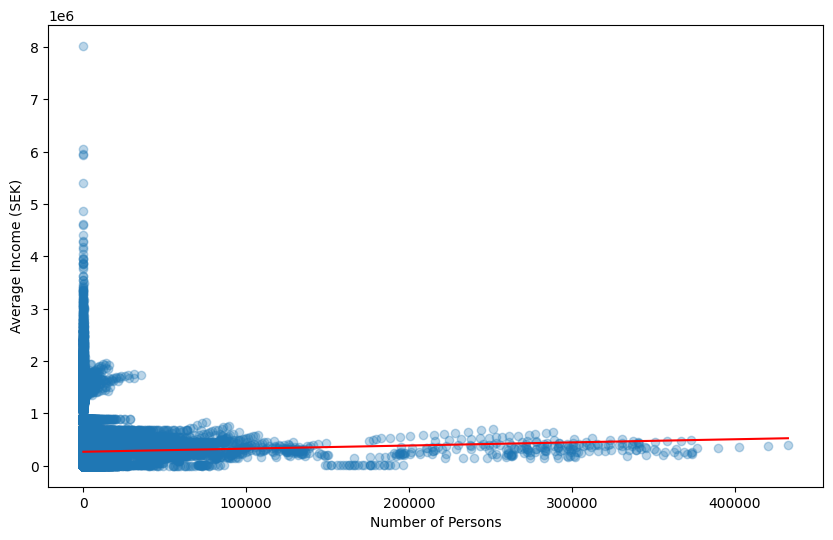

In [8]:
df_plot = df[df['number_of_persons'] > 0]

X = df_plot[["number_of_persons"]].values
y = df_plot["avg_income"].values

model = LinearRegression()
model.fit(X, y)

xfit = np.linspace(X.min(), X.max(), 100)[:, np.newaxis]
yfit = model.predict(xfit)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.3)
plt.plot(xfit, yfit, color="red")
plt.xlabel("Number of Persons")
plt.ylabel("Average Income (SEK)")
plt.show()


Task 2: do the same for **polynomial regression.**

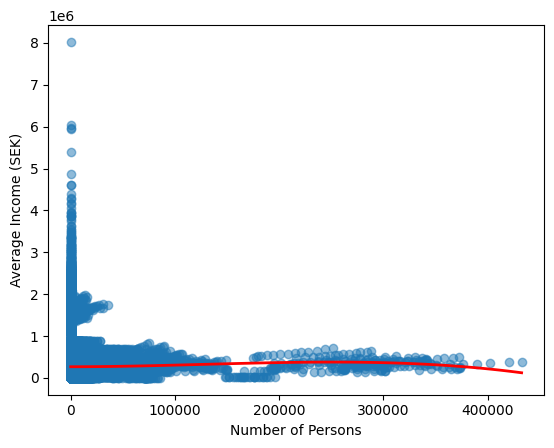

In [9]:
X = df_plot[["number_of_persons"]].values
y = df_plot["avg_income"].values

poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model.fit(X,y)

xfit = np.linspace(X.min(), X.max(), 100)[:, np.newaxis]
yfit = poly_model.predict(xfit)

plt.scatter(X, y, alpha=0.5)
plt.plot(xfit, yfit, color="red", linewidth=2)
plt.xlabel("Number of Persons")
plt.ylabel("Average Income (SEK)")
plt.show()

- - - 
## Clustering


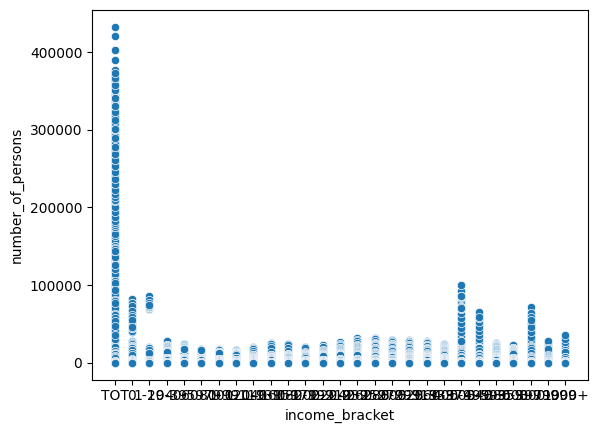

In [6]:
sns.scatterplot(data=df, y="number_of_persons", x="income_bracket");

3. Run k-Means clustering (with 3 clusters)

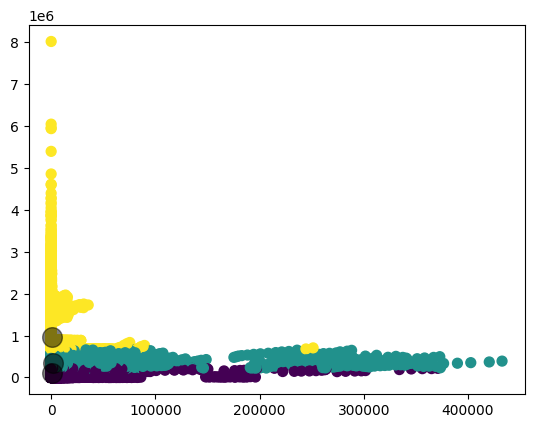

In [7]:

X = df[["number_of_persons", "avg_income"]].values

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

**4. Run a Gaussian Mixture Model (GMM) in the same way and plot the result!**

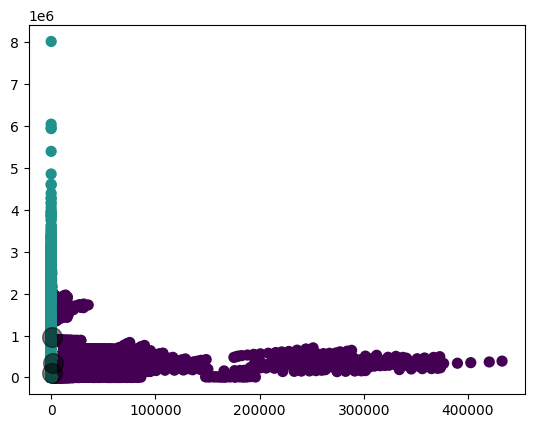

In [8]:
gmm = GMM(n_components=3).fit(X)
labels = gmm.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

**5. Run the GMM model several times. Is the result always the same?** 

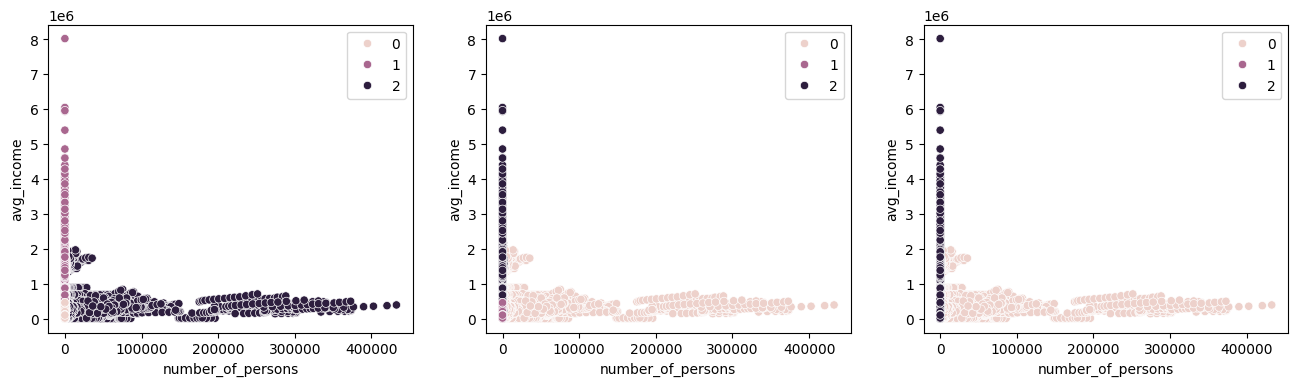

In [9]:
X = df[["number_of_persons", "avg_income"]].values

def plot_gmm(i, g):
    model = GMM(n_components=3, random_state=7 + i)
    y = model.fit_predict(X)
    sns.scatterplot(ax=g, x=df["number_of_persons"], y=df["avg_income"], hue=y)

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for i in range(3):
    plot_gmm(i, ax[i])

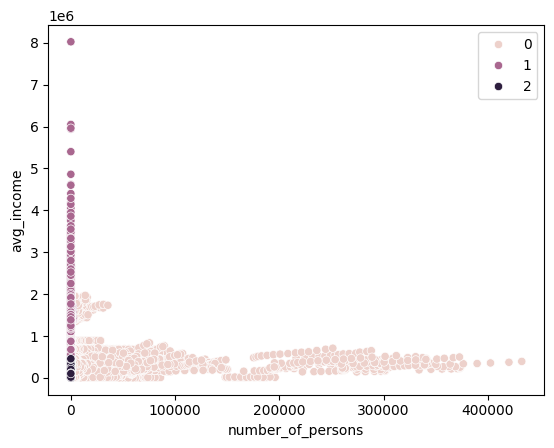

In [10]:
model = GMM(n_components=3, n_init=10)
y = model.fit_predict(X)
sns.scatterplot(x=df["number_of_persons"], y=df["avg_income"], hue=y);

- - - 
## Decision Trees & Model Validation

**6. Split the data into a _train_ and _test_ set**

In [33]:
df.head()

df = df[(df['number_of_persons'] > 0) & (df['income_bracket'] != 'TOT')]

X = df[["sex", "age", "year", "number_of_persons", "level_of_education"]]
y = df["avg_income"]


categorical = ["sex", "age", "level_of_education"]
numerical = ["year", "number_of_persons"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numerical)
    ]
)

clf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(max_depth=4, random_state=0))
])

y = df["income_bracket"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

**7. Train a decision tree classifier and produce predictions on the test set.** 

In [35]:
clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)

print(y_pred)

['220-239' '220-239' '400-499' ... '60-79' '80-99' '60-79']


**8. Evaluate how well your classifier performs.** Look at:

- accuracy;
- F1-scores
- the absolute number of _wrong_ predictions your classifier made.

In [42]:
print(accuracy_score(y_test, y_pred))

0.07828752452897947


In [43]:
print(f1_score(y_test, y_pred, average='macro'))

0.039149078180092986


In [41]:
tot = len(y_test)
wrong = 0
for i,j in zip(y_test, y_pred):
    if i != j:
        wrong +=1

print(f"{wrong} wrong out of {tot} total")

71865 wrong out of 77969 total


**9. Plot a _confusion matrix_** that shows how often a class was mistakenly for another.

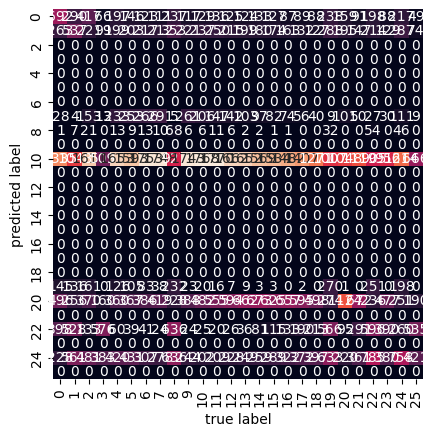

In [44]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

**10. What is the first criterion your decision tree splits on? Is there a feature that is (almost) never used?**

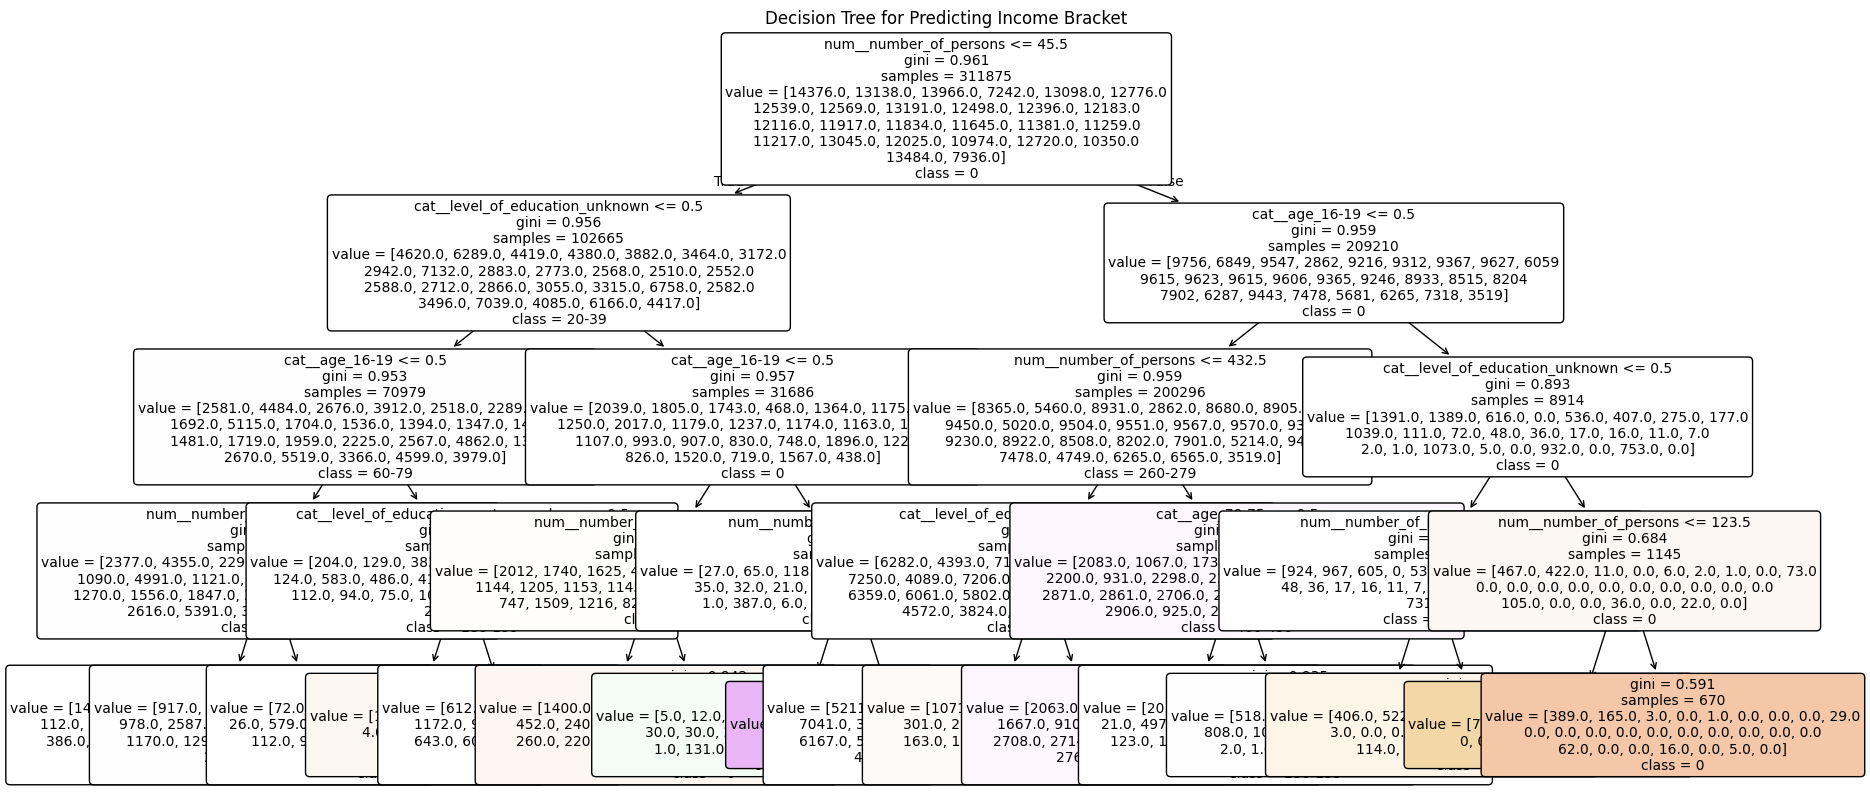

In [ ]:
# clf_pipeline.fit(X_train, y_train)

clf = clf_pipeline.named_steps["classifier"]

feature_names = clf_pipeline.named_steps["preprocessor"].get_feature_names_out()

plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    feature_names=feature_names,
    class_names=clf.classes_,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree for Predicting Income Bracket")
plt.show()

- - - 
## SVMs, Hyperparameters, and Cross-Validation

**11. Split your data into _train_ and _test_ set again**  
Here we once again use one hot encoding, but this time with the Pandas "get_dummies" method. 

In [ ]:
print(df.head())
print(df.columns.to_list()) # ['sex', 'age', 'income_bracket', 'year', 'total_sum_sek_millions', 'number_of_persons', 'region_name', 'level_of_education', 'avg_income']

df = df[(df['number_of_persons'] > 0) & (df['income_bracket'] != 'TOT')]

df_sample = df.sample(n=10000, random_state=111) 

X = pd.get_dummies(df_sample[["region_name", "level_of_education"]], columns=["region_name", "level_of_education"])
y = df_sample["sex"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=111)

# print(X_train.head())
# print(y_train.head())

   sex    age income_bracket  year  total_sum_sek_millions  number_of_persons  \
1  Man  16-19              0  2018                     0.0              13357   
2  Man  16-19           1-19  2018                   137.9              17417   
3  Man  16-19          20-39  2018                   106.1               3763   
4  Man  16-19          40-59  2018                    77.2               1574   
5  Man  16-19          60-79  2018                    50.9                745   

  region_name       level_of_education    avg_income  
1   Stockholm  primary/lower secondary      0.000000  
2   Stockholm  primary/lower secondary   7917.551817  
3   Stockholm  primary/lower secondary  28195.588626  
4   Stockholm  primary/lower secondary  49047.013977  
5   Stockholm  primary/lower secondary  68322.147651  
['sex', 'age', 'income_bracket', 'year', 'total_sum_sek_millions', 'number_of_persons', 'region_name', 'level_of_education', 'avg_income']


**12. Fit a support vector classifier to the data and evaluate its accuracy!** 

In [15]:
from sklearn.svm import SVC

model = SVC(kernel='linear', C=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.502125


**13. Using the same classifier as above, perform _10-fold cross-validation_ to evaluate its accuracy!** 

In [ ]:
from sklearn.model_selection import cross_val_score

clf = SVC(kernel='linear', C=1.0)

cvs = cross_val_score(clf, X, y, cv=10)
print(cvs)


[0.492 0.525 0.524 0.533 0.523 0.508 0.51  0.483 0.5   0.493]


**14. Perform grid search to find the best kernel and regularization value for our task!**

In [ ]:
# Define parameter grid
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [1, 10, 100]
}

# Create the SVC model
svc = SVC()

# Set up GridSearchCV
grid = GridSearchCV(svc, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# Evaluate on test set
y_pred = grid.predict(X_test)
print("Test set accuracy:", accuracy_score(y_test, y_pred))

Best parameters: {'C': 1, 'kernel': 'linear'}
Best cross-validation score: 0.522
Test set accuracy: 0.502125


# Tasks from exercise 5 starts here

In [2]:
try:
    from rich import load_ipython_extension
    %load_ext rich
except ImportError:
    try:
        from rich import pretty
        pretty.install()
    except ImportError:
        pass
    
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

df = pd.read_csv("../data/manipulated_data.csv")
df.head()

level_of_education = {
    "primary and lower secondary education": "primary/lower secondary",
    "upper secondary education": "upper secondary",
    "post secondary education": "post-secondary",
    "no information about level of educational attainment": "unknown",
}

df["level_of_education"] = df["level_of_education"].replace(level_of_education)

df["avg_income"] = df["total_sum_sek_millions"] * 1_000_000 / df["number_of_persons"]

df = df[(df['number_of_persons'] > 0) & (df['income_bracket'] != 'TOT')]

#df

## Permutation feature importance


In [11]:
print(df.columns.to_list())

df_sample = df.sample(n=10000, random_state=111) 

X = df_sample[
    [
    'year', 
    'total_sum_sek_millions', 
    'number_of_persons', 
    'avg_income'
    ]
]

df_sample = df_sample.join(pd.get_dummies(df[["age", "income_bracket", 'level_of_education']]))

y = df_sample["sex"]
model = SVC(C=1.0, gamma=0.0001, kernel="rbf")

['sex', 'age', 'income_bracket', 'year', 'total_sum_sek_millions', 'number_of_persons', 'region_name', 'level_of_education', 'avg_income']


**1. Make a train/test split, train the model, and calculate its accuracy on the test set.**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111, train_size=0.8)

clf = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.526


**2. Calculate permutation importance over the input features.**

In [14]:
result = permutation_importance(model, X_test, y_test, n_repeats=10,random_state=0)

result["importances_mean"]
pd.DataFrame([X.columns, result['importances_mean']]).T.set_index(0)

,1
0,
year,0.0006
total_sum_sek_millions,-0.0037
number_of_persons,0.00635
avg_income,0.0131


**3. Change your train/test data** (e.g. `X_train`, `X_test`) **to only include the _two most important features_.** Then retrain the model with that & evaluate it again.

In [3]:
df_sample = df.sample(n=10000, random_state=111) 

X = df_sample[
    [
        "number_of_persons",
        "avg_income",
    ]
]

y = df_sample["sex"]
model = SVC(C=1.0, gamma=0.0001, kernel="rbf")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111, train_size=0.8)

clf = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.5245


**4. Do the same thing, but train the model on the _two least important features only_.**

In [4]:
df_sample = df.sample(n=10000, random_state=111) 

X = df_sample[
    [
        "year",
        "total_sum_sek_millions",
    ]
]

y = df_sample["sex"]
model = SVC(C=1.0, gamma=0.0001, kernel="rbf")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111, train_size=0.8)

clf = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.512


**5. What accuracy score would you get if you always guessed the majority class?** 

In [6]:
y_train.value_counts()

y_majority = ["Man"] * len(y_test)
accuracy_score(y_majority, y_test)

0.517

- - - 
# Statistical testing

**6. Which of our measurement variables are _normally distributed_?**

In [10]:
df_sub = df[(df["sex"] == "Woman")]

print(pg.normality(df_sub))

                               W           pval  normal
year                    0.943543  1.392342e-109   False
total_sum_sek_millions  0.129727  4.176041e-197   False
number_of_persons       0.198630  4.344083e-194   False
avg_income              0.769875  2.574038e-151   False


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 188495.
  res = hypotest_fun_out(*samples, **kwds)


**7. Which of the measurement variables are _correlated_?** Perform a pairwise correlation analysis with all the columns of our dataframe.

In [ ]:
cols = ['year', 'total_sum_sek_millions', 'number_of_persons','avg_income']
pairs = []

def backtrack(start, path):
    if len(path) == 2:
        pairs.append(tuple(path))
        return
    for i in range(start, len(cols)):
        backtrack(i+1, path + [cols[i]])

backtrack(0,[])

print(pairs)
correlations = []
for pair in pairs:
    correlations.append(pg.corr(df[pair[0]], df[pair[1]]))

print(correlations)


pg.pairwise_corr(df_sub, method="pearson")

[('year', 'total_sum_sek_millions'), ('year', 'number_of_persons'), ('year', 'avg_income'), ('total_sum_sek_millions', 'number_of_persons'), ('total_sum_sek_millions', 'avg_income'), ('number_of_persons', 'avg_income')]
[              n         r         CI95%         p-val       BF10  power
pearson  389844  0.018018  [0.01, 0.02]  2.285650e-29  6.178e+24    1.0,               n         r         CI95%     p-val   BF10  power
pearson  389844 -0.003002  [-0.01, 0.0]  0.060865  0.012  0.466,               n         r         CI95%         p-val       BF10  power
pearson  389844  0.024262  [0.02, 0.03]  7.508642e-52  1.401e+47    1.0,               n         r         CI95%  p-val BF10  power
pearson  389844  0.810655  [0.81, 0.81]    0.0  inf    1.0,               n         r         CI95%  p-val BF10  power
pearson  389844  0.138467  [0.14, 0.14]    0.0  inf    1.0,               n         r         CI95%         p-val       BF10  power
pearson  389844  0.030664  [0.03, 0.03]  9.572649e

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,year,total_sum_sek_millions,pearson,two-sided,188495,0.019853,"[0.02, 0.02]",6.694727e-18,3.938e+13,1.000000
1,year,number_of_persons,pearson,two-sided,188495,-0.004924,"[-0.01, -0.0]",3.252925e-02,0.028,0.570616
2,year,avg_income,pearson,two-sided,188495,0.031274,"[0.03, 0.04]",5.182042e-42,3.253e+37,1.000000
3,total_sum_sek_millions,number_of_persons,pearson,two-sided,188495,0.823880,"[0.82, 0.83]",0.000000e+00,inf,1.000000
4,total_sum_sek_millions,avg_income,pearson,two-sided,188495,0.112890,"[0.11, 0.12]",0.000000e+00,inf,1.000000
5,number_of_persons,avg_income,pearson,two-sided,188495,0.013002,"[0.01, 0.02]",1.649779e-08,2.402e+04,0.999886


**8. Make a new Pandas DataFrame with "classifier correctness" labels.**